## Correlation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Read Data

In [2]:
data = pd.read_csv('../DoHBrwTest.csv')
data.shape

(53860, 35)

### Train - Test Split

In [3]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion'], axis=1),
    data['is_intrusion'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((37702, 34), (16158, 34))

## Correlation heatmap

<AxesSubplot:>

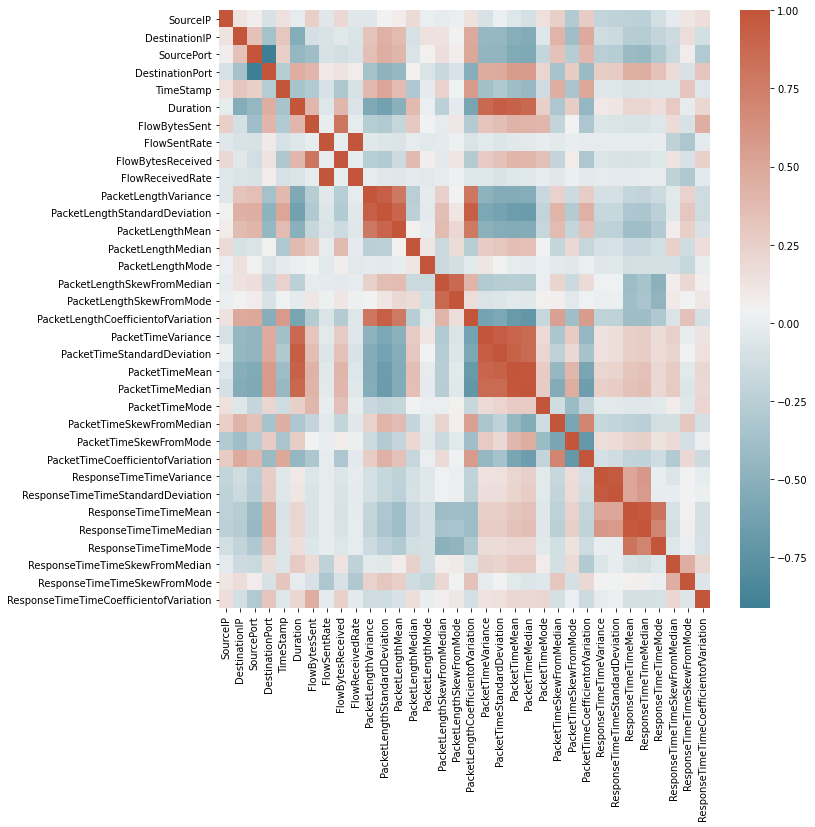

In [4]:
corrmat = X_train.corr(method='pearson')
cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat, cmap=cmap)

In the plot above, the dark orange squares correspond to highly correlated features (>0.8). Darker blue squares corresponds to negatively correlated features (<-0.8).

The diagonal represents the correlation of a feature with itself, therefore the value is 1.

We can see that there are a few features that are highly correlated.

## Correlation scatterplots

In [6]:
c = 0
for i in corrmat.loc['FlowSentRate']:
    if i > 0.8:
        print(corrmat.columns[c], i)
    c = c + 1

FlowSentRate 1.0
FlowReceivedRate 0.9976012065972045


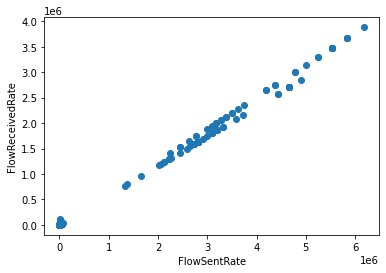

In [7]:
plt.scatter(X_train['FlowSentRate'], X_train['FlowReceivedRate'])
plt.ylabel('FlowReceivedRate')
plt.xlabel('FlowSentRate')
plt.show()

In [8]:
c = 0
for i in corrmat.loc['FlowReceivedRate']:
    if i > 0.8:
        print(corrmat.columns[c], i)
    c = c + 1

FlowSentRate 0.9976012065972045
FlowReceivedRate 1.0


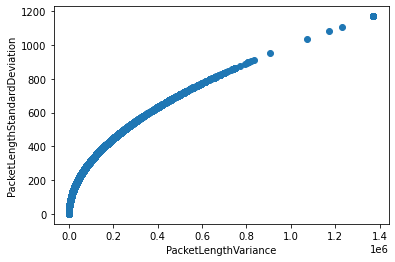

In [9]:
# now, let's plot the variables

plt.scatter(X_train['PacketLengthVariance'], X_train['PacketLengthStandardDeviation'])
plt.ylabel('PacketLengthStandardDeviation')
plt.xlabel('PacketLengthVariance')
plt.show()

We see that the correlation of the second pair of variables is not quite linear.

Next, let's identify a couple of negatively correlated variables:

In [10]:
c = 0
for i in corrmat.loc['SourcePort']:
    if i <- 0.6:
        print(corrmat.columns[c], i)
        
    c = c + 1

DestinationPort -0.9135717167732196


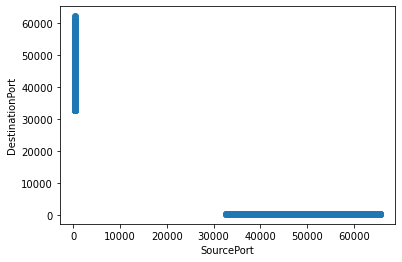

In [11]:
# now, let's plot the variables

plt.scatter(X_train['SourcePort'], X_train['DestinationPort'])
plt.ylabel('DestinationPort')
plt.xlabel('SourcePort')
plt.show()

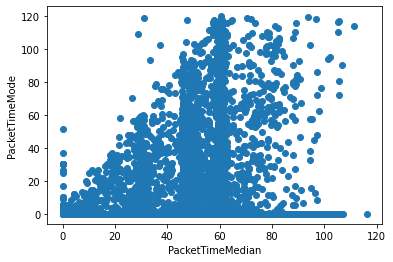

In [12]:
plt.scatter(X_train['PacketTimeMedian'], X_train['PacketTimeMode'])
plt.ylabel('PacketTimeMode')
plt.xlabel('PacketTimeMedian')
plt.show()

## Remove correlated

### Brute force approach

In [13]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                colname = corr_matrix.columns[j]
                col_corr.add(colname)
    return col_corr

In [14]:
corr_features = correlation(X_train, 0.8)
len(set(corr_features))

0.9135717167732196 DestinationPort SourcePort
0.8052254030671949 FlowBytesReceived FlowBytesSent
0.9976012065972045 FlowReceivedRate FlowSentRate
0.9337102648845788 PacketLengthStandardDeviation PacketLengthVariance
0.8977411579883101 PacketLengthMean PacketLengthStandardDeviation
0.8736424763464272 PacketLengthSkewFromMode PacketLengthSkewFromMedian
0.9359071130680737 PacketLengthCoefficientofVariation PacketLengthStandardDeviation
0.8780490242508532 PacketTimeVariance Duration
0.9426776725219304 PacketTimeStandardDeviation Duration
0.9425056674210235 PacketTimeStandardDeviation PacketTimeVariance
0.9236521000772274 PacketTimeMean Duration
0.8954213055946693 PacketTimeMean PacketTimeVariance
0.9226344621049922 PacketTimeMean PacketTimeStandardDeviation
0.8814519460167897 PacketTimeMedian Duration
0.8598988460578089 PacketTimeMedian PacketTimeVariance
0.863168144990829 PacketTimeMedian PacketTimeStandardDeviation
0.9865936659025887 PacketTimeMedian PacketTimeMean
0.9649303443172608 Res

12

We can see that 9 features are highly correlated with other features in the training set. 

Very likely, by removing these correlated features, the performance of your machine learning models will drop very little, if at all. We can go ahead and drop the features like we have done in previous methods.

In [15]:
corr_features

{'Duration',
 'FlowBytesSent',
 'FlowSentRate',
 'PacketLengthSkewFromMedian',
 'PacketLengthStandardDeviation',
 'PacketLengthVariance',
 'PacketTimeMean',
 'PacketTimeStandardDeviation',
 'PacketTimeVariance',
 'ResponseTimeTimeMean',
 'ResponseTimeTimeVariance',
 'SourcePort'}

In [16]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((37702, 22), (16158, 22))

By removing correlated columns we reduced the feature space from 16 numerical columns to 14.

### Second approach

The second approach looks to identify groups of highly correlated features. And then, we can make further investigation within these groups to decide which feature we keep and which one we remove.

In [17]:
data = pd.read_csv('../DoHBrwTest.csv')
data.shape

(53860, 35)

In [18]:
# separate train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion'], axis=1),
    data['is_intrusion'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((37702, 34), (16158, 34))

In [19]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,FlowReceivedRate,FlowSentRate,0.997601
1,FlowSentRate,FlowReceivedRate,0.997601
2,PacketTimeMedian,PacketTimeMean,0.986594
3,PacketTimeMean,PacketTimeMedian,0.986594
4,ResponseTimeTimeMean,ResponseTimeTimeMedian,0.975555


In [20]:
grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 10 correlated groups
out of 34 total features


In [21]:
for group in correlated_groups:
    print(group)
    print()

           feature1      feature2      corr
0  FlowReceivedRate  FlowSentRate  0.997601

            feature1                     feature2      corr
2   PacketTimeMedian               PacketTimeMean  0.986594
27  PacketTimeMedian                     Duration  0.881452
33  PacketTimeMedian  PacketTimeStandardDeviation  0.863168
35  PacketTimeMedian           PacketTimeVariance  0.859899

                feature1                feature2      corr
4   ResponseTimeTimeMean  ResponseTimeTimeMedian  0.975555
37  ResponseTimeTimeMean    ResponseTimeTimeMode  0.817118

                   feature1                           feature2     corr
6  ResponseTimeTimeVariance  ResponseTimeTimeStandardDeviation  0.96493

                              feature1                       feature2  \
12  PacketLengthCoefficientofVariation  PacketLengthStandardDeviation   

        corr  
12  0.935907  

                feature1                       feature2     corr
14  PacketLengthVariance  PacketLengthStanda

In [22]:
group = correlated_groups[1]
group

,feature1,feature2,corr
2,PacketTimeMedian,PacketTimeMean,0.986594
27,PacketTimeMedian,Duration,0.881452
33,PacketTimeMedian,PacketTimeStandardDeviation,0.863168
35,PacketTimeMedian,PacketTimeVariance,0.859899


Alternatively, we could build a **machine learning algorithm using all the features from the above list, and select the more predictive one**.

In [24]:
from sklearn.ensemble import RandomForestClassifier

# add all features of the group to a list
features = list(group['feature2'].unique())+['PacketTimeMedian']

# train a random forest 
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

RandomForestClassifier(max_depth=4, n_estimators=200, random_state=39)

In [25]:
# get the feature importance attributed by the random forest model

importance = pd.concat(
    [pd.Series(features),
     pd.Series(rf.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']

# sort features by importance, most important first
importance.sort_values(by='importance', ascending=False)

,feature,importance
3,PacketTimeVariance,0.315142
2,PacketTimeStandardDeviation,0.290149
1,Duration,0.162344
0,PacketTimeMean,0.156890
4,PacketTimeMedian,0.075476


In this case, feature dst_host_srv_serror_rate shows the highest importance according to random forests. Then, I would select Dst_host_serror_rate, and remove all the remaining features from this group from the dataset.

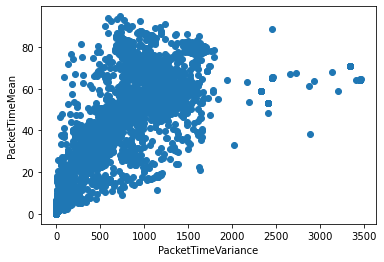

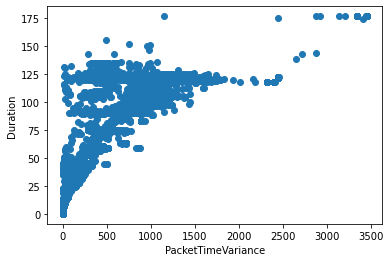

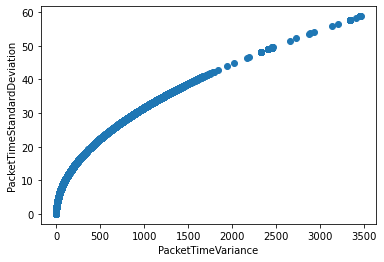

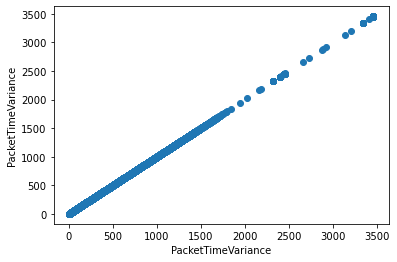

In [26]:
# Plot the correlation of the features in the correlated group from the previous cell

for feature in group['feature2']:
    plt.scatter(X_train['PacketTimeVariance'], X_train[feature])
    plt.xlabel('PacketTimeVariance')
    plt.ylabel(feature)
    plt.show()

## Read Data

In [40]:
data = pd.read_csv('../KDDTrain.csv')
data.shape

(125972, 42)

In [42]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion','dst_host_rerror_rate','dst_host_serror_rate','dst_host_srv_count','hot',
                      'num_compromised','rerror_rate','serror_rate','srv_rerror_rate','srv_serror_rate'],
                       axis=1),         # drop the target and features
    data['is_intrusion'],               # just the target
    test_size=0.2,
    random_state=0)

X_train.shape, X_test.shape

((100777, 32), (25195, 32))

## Standardize Data

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers

In [44]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression

In [46]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=0.1).fit(X_train, y_train)

CPU times: user 88.9 ms, sys: 202 ms, total: 291 ms
Wall time: 5.38 s


In [47]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.43802341734471123
F1 Score: 0.6080553633217993
FPR: 0.9960723284422707
TPR: 0.9386377232715153


### Naive Bayes

In [48]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-09).fit(X_train, y_train)

CPU times: user 62.6 ms, sys: 8.59 ms, total: 71.2 ms
Wall time: 69.3 ms


In [49]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.46441754316332606
F1 Score: 0.6342692974848223
FPR: 1.0
TPR: 1.0


### Random Forest

In [50]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100).fit(X_train, y_train)

CPU times: user 5.21 s, sys: 60.6 ms, total: 5.27 s
Wall time: 5.27 s


In [51]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.5355824568366739
F1 Score: 0.3736022989766641
FPR: 1.0
TPR: 1.0


### KNN

In [52]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='brute',leaf_size=1,n_neighbors=2,weights='distance').fit(X_train, y_train)

CPU times: user 9.35 ms, sys: 1.51 ms, total: 10.9 ms
Wall time: 8.95 ms


In [53]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.24806509228021434
f1: 0.37485563438376507
fpr: 0.9577590040017786
tpr: 0.4854285958465088


### CatBoost

In [54]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.5693950	total: 78.8ms	remaining: 3.86s
1:	learn: 0.4955299	total: 96.7ms	remaining: 2.32s
2:	learn: 0.4181841	total: 115ms	remaining: 1.8s
3:	learn: 0.3506583	total: 134ms	remaining: 1.54s
4:	learn: 0.3043849	total: 153ms	remaining: 1.37s
5:	learn: 0.2584266	total: 171ms	remaining: 1.25s
6:	learn: 0.2230299	total: 188ms	remaining: 1.16s
7:	learn: 0.2012502	total: 206ms	remaining: 1.08s
8:	learn: 0.1759236	total: 224ms	remaining: 1.02s
9:	learn: 0.1610481	total: 242ms	remaining: 969ms
10:	learn: 0.1433473	total: 261ms	remaining: 925ms
11:	learn: 0.1250116	total: 279ms	remaining: 885ms
12:	learn: 0.1129294	total: 297ms	remaining: 846ms
13:	learn: 0.1016858	total: 315ms	remaining: 810ms
14:	learn: 0.0923072	total: 333ms	remaining: 777ms
15:	learn: 0.0831797	total: 351ms	remaining: 747ms
16:	learn: 0.0764919	total: 370ms	remaining: 718ms
17:	learn: 0.0722767	total: 388ms	remaining: 690ms
18:	learn: 0.0671282	total: 406ms	remaining: 663ms
19:	learn: 0.0630250	total: 425ms	remain

In [55]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.5355824568366739
F1 Score: 0.3736022989766641
FPR: 1.0
TPR: 1.0


## Model Evaluation

In [56]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../KDDTest.csv")
test_df.shape

(22543, 42)

In [57]:
# Create feature matrix X and target vextor y
y_eval = test_df['is_intrusion']
X_eval = test_df.drop(columns=['is_intrusion','dst_host_rerror_rate','dst_host_serror_rate','dst_host_srv_count',
                               'hot','num_compromised','rerror_rate','serror_rate','srv_rerror_rate',
                               'srv_serror_rate'])

### Model Evaluation - Logistic Regression


In [58]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=0.1)
modelLR.fit(X_train, y_train)

LogisticRegression(C=0.1, n_jobs=-1, random_state=42)

In [59]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [60]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  0.954265358167042
Testing accuracy is  0.43802341734471123


In [61]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.43802341734471123
F1 Score: 0.6080553633217993
Precision Score: 0.4496806419914838
Recall Score: 0.9386377232715153
Confusion Matrix:
 [[   53 13441]
 [  718 10983]]


### Cross validation - Logistic Regression



In [62]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.82855 (+/- 0.02306)
F1 Score: 0.84488 (+/- 0.02034)
Precision: 0.87130 (+/- 0.03014)
Recall: 0.82022 (+/- 0.02543)


### Model Evaluation - Naive Bayes




In [63]:
modelNB = GaussianNB(var_smoothing=1e-09)
modelNB.fit(X_train, y_train)

GaussianNB()

In [64]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [65]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  0.8943409706579875
Testing accuracy is  0.46441754316332606


In [66]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))

Performance measures for test:
--------
Accuracy: 0.46441754316332606
F1 Score: 0.6342692974848223
Precision Score: 0.46441754316332606
Recall Score: 1.0
Confusion Matrix:
 [[    0 13494]
 [    0 11701]]


### Cross validation - Naive Bayes



In [67]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.78956 (+/- 0.05597)
F1 Score: 0.80355 (+/- 0.03588)
Precision: 0.87025 (+/- 0.14522)
Recall: 0.75476 (+/- 0.11566)


### Model Evaluation - Random Forest




In [68]:
modelRF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, random_state=0)

In [69]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [70]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  0.9999702313027774
Testing accuracy is  0.5355824568366739


In [71]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.5355824568366739
F1 Score: 0.3736022989766641
Precision Score: 0.28684856807120773
Recall Score: 0.5355824568366739
Confusion Matrix:
 [[13494     0]
 [11701     0]]


### Cross validation - Random Forest



In [72]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.98665 (+/- 0.00439)
F1 Score: 0.98827 (+/- 0.00386)
Precision: 0.98877 (+/- 0.00523)
Recall: 0.98776 (+/- 0.00498)


### Model Evaluation - KNN

In [73]:
modelKNN = KNeighborsClassifier(algorithm='brute',leaf_size=1,n_neighbors=2,weights='distance')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=1, n_neighbors=2,
                     weights='distance')

In [74]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [75]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9999603084037032
Testing accuracy is  0.24806509228021434


In [76]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.24806509228021434
F1 Score: 0.37485563438376507
Precision Score: 0.3053106858740056
Recall Score: 0.4854285958465088
Confusion Matrix:
 [[  570 12924]
 [ 6021  5680]]


### Cross validation - KNN



In [77]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.97831 (+/- 0.00548)
F1 Score: 0.98092 (+/- 0.00477)
Precision: 0.98250 (+/- 0.00768)
Recall: 0.97935 (+/- 0.00329)


### Model Evaluation - CatBoost

In [78]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.5693950	total: 17.7ms	remaining: 868ms
1:	learn: 0.4955299	total: 34.7ms	remaining: 832ms
2:	learn: 0.4181841	total: 51.7ms	remaining: 811ms
3:	learn: 0.3506583	total: 69.1ms	remaining: 794ms
4:	learn: 0.3043849	total: 86.6ms	remaining: 779ms
5:	learn: 0.2584266	total: 104ms	remaining: 763ms
6:	learn: 0.2230299	total: 121ms	remaining: 745ms
7:	learn: 0.2012502	total: 138ms	remaining: 725ms
8:	learn: 0.1759236	total: 156ms	remaining: 709ms
9:	learn: 0.1610481	total: 173ms	remaining: 694ms
10:	learn: 0.1433473	total: 190ms	remaining: 675ms
11:	learn: 0.1250116	total: 207ms	remaining: 655ms
12:	learn: 0.1129294	total: 224ms	remaining: 637ms
13:	learn: 0.1016858	total: 241ms	remaining: 621ms
14:	learn: 0.0923072	total: 259ms	remaining: 604ms
15:	learn: 0.0831797	total: 276ms	remaining: 587ms
16:	learn: 0.0764919	total: 294ms	remaining: 570ms
17:	learn: 0.0722767	total: 311ms	remaining: 553ms
18:	learn: 0.0671282	total: 328ms	remaining: 536ms
19:	learn: 0.0630250	total: 345ms	re

In [79]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [80]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  0.9951774710499419
Testing accuracy is  0.5355824568366739


In [81]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.5355824568366739
F1 Score: 0.3736022989766641
Precision Score: 0.28684856807120773
Recall Score: 0.5355824568366739
Confusion Matrix:
 [[13494     0]
 [11701     0]]


### Cross validation - CatBoost

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.6042292	total: 11.6ms	remaining: 568ms
1:	learn: 0.5385339	total: 23.3ms	remaining: 559ms
2:	learn: 0.4814855	total: 34.7ms	remaining: 543ms
3:	learn: 0.4351508	total: 45.6ms	remaining: 524ms
4:	learn: 0.3969439	total: 56.9ms	remaining: 512ms
5:	learn: 0.3687990	total: 68.4ms	remaining: 502ms
6:	learn: 0.3365090	total: 79.5ms	remaining: 488ms
7:	learn: 0.3074418	total: 91.2ms	remaining: 479ms
8:	learn: 0.2851295	total: 102ms	remaining: 465ms
9:	learn: 0.2678611	total: 113ms	remaining: 453ms
10:	learn: 0.2506840	total: 125ms	remaining: 442ms
11:	learn: 0.2376296	total: 136ms	remaining: 430ms
12:	learn: 0.2224854	total: 147ms	remaining: 419ms
13:	learn: 0.2041242	total: 159ms	remaining: 408ms
14:	learn: 0.1881914	total: 170ms	remaining: 397ms
15:	learn: 0.1774497	total: 181ms	remaining: 385ms
16:	learn: 0.1651783	total: 193ms	remaining: 374ms
17:	learn: 0.1552609	total: 204ms	remaining: 362ms
18:	learn: 0.1476606	total: 215ms	remaining: 350ms
19:	learn: 0.1413867	total: 227ms

18:	learn: 0.1526684	total: 209ms	remaining: 342ms
19:	learn: 0.1454927	total: 220ms	remaining: 330ms
20:	learn: 0.1395445	total: 231ms	remaining: 319ms
21:	learn: 0.1321891	total: 242ms	remaining: 308ms
22:	learn: 0.1253332	total: 254ms	remaining: 298ms
23:	learn: 0.1200736	total: 265ms	remaining: 287ms
24:	learn: 0.1152728	total: 276ms	remaining: 276ms
25:	learn: 0.1115536	total: 286ms	remaining: 264ms
26:	learn: 0.1058456	total: 298ms	remaining: 254ms
27:	learn: 0.1022842	total: 309ms	remaining: 243ms
28:	learn: 0.0997450	total: 320ms	remaining: 232ms
29:	learn: 0.0971417	total: 332ms	remaining: 221ms
30:	learn: 0.0948084	total: 343ms	remaining: 210ms
31:	learn: 0.0931017	total: 354ms	remaining: 199ms
32:	learn: 0.0912618	total: 365ms	remaining: 188ms
33:	learn: 0.0896197	total: 375ms	remaining: 177ms
34:	learn: 0.0870783	total: 386ms	remaining: 166ms
35:	learn: 0.0856334	total: 397ms	remaining: 155ms
36:	learn: 0.0835309	total: 408ms	remaining: 143ms
37:	learn: 0.0823902	total: 419

30:	learn: 0.0931273	total: 347ms	remaining: 213ms
31:	learn: 0.0911314	total: 358ms	remaining: 201ms
32:	learn: 0.0887038	total: 370ms	remaining: 190ms
33:	learn: 0.0869574	total: 381ms	remaining: 179ms
34:	learn: 0.0855995	total: 392ms	remaining: 168ms
35:	learn: 0.0845581	total: 403ms	remaining: 157ms
36:	learn: 0.0833432	total: 414ms	remaining: 146ms
37:	learn: 0.0824486	total: 425ms	remaining: 134ms
38:	learn: 0.0812474	total: 436ms	remaining: 123ms
39:	learn: 0.0802499	total: 447ms	remaining: 112ms
40:	learn: 0.0787643	total: 458ms	remaining: 101ms
41:	learn: 0.0782345	total: 469ms	remaining: 89.4ms
42:	learn: 0.0776036	total: 480ms	remaining: 78.1ms
43:	learn: 0.0761744	total: 491ms	remaining: 66.9ms
44:	learn: 0.0756870	total: 502ms	remaining: 55.7ms
45:	learn: 0.0752362	total: 513ms	remaining: 44.6ms
46:	learn: 0.0741305	total: 524ms	remaining: 33.4ms
47:	learn: 0.0731675	total: 534ms	remaining: 22.3ms
48:	learn: 0.0720139	total: 546ms	remaining: 11.1ms
49:	learn: 0.0711040	to

48:	learn: 0.0701971	total: 542ms	remaining: 11.1ms
49:	learn: 0.0697560	total: 553ms	remaining: 0us
0:	learn: 0.6042292	total: 11.6ms	remaining: 568ms
1:	learn: 0.5385339	total: 23.5ms	remaining: 563ms
2:	learn: 0.4814855	total: 34.7ms	remaining: 543ms
3:	learn: 0.4351508	total: 45.8ms	remaining: 527ms
4:	learn: 0.3969439	total: 57.1ms	remaining: 514ms
5:	learn: 0.3687990	total: 68.5ms	remaining: 502ms
6:	learn: 0.3365090	total: 79.6ms	remaining: 489ms
7:	learn: 0.3074418	total: 91.1ms	remaining: 478ms
8:	learn: 0.2851295	total: 102ms	remaining: 466ms
9:	learn: 0.2678611	total: 113ms	remaining: 454ms
10:	learn: 0.2506840	total: 124ms	remaining: 441ms
11:	learn: 0.2376296	total: 136ms	remaining: 430ms
12:	learn: 0.2224854	total: 148ms	remaining: 422ms
13:	learn: 0.2041242	total: 159ms	remaining: 410ms
14:	learn: 0.1881914	total: 170ms	remaining: 397ms
15:	learn: 0.1774497	total: 182ms	remaining: 386ms
16:	learn: 0.1651783	total: 193ms	remaining: 375ms
17:	learn: 0.1552609	total: 204ms	

10:	learn: 0.2367573	total: 121ms	remaining: 430ms
11:	learn: 0.2223170	total: 132ms	remaining: 419ms
12:	learn: 0.2087509	total: 143ms	remaining: 407ms
13:	learn: 0.1987260	total: 155ms	remaining: 397ms
14:	learn: 0.1892494	total: 166ms	remaining: 387ms
15:	learn: 0.1786029	total: 178ms	remaining: 377ms
16:	learn: 0.1690362	total: 189ms	remaining: 368ms
17:	learn: 0.1598992	total: 201ms	remaining: 357ms
18:	learn: 0.1526684	total: 212ms	remaining: 346ms
19:	learn: 0.1454927	total: 223ms	remaining: 334ms
20:	learn: 0.1395445	total: 234ms	remaining: 324ms
21:	learn: 0.1321891	total: 246ms	remaining: 313ms
22:	learn: 0.1253332	total: 257ms	remaining: 302ms
23:	learn: 0.1200736	total: 268ms	remaining: 291ms
24:	learn: 0.1152728	total: 280ms	remaining: 280ms
25:	learn: 0.1115536	total: 291ms	remaining: 268ms
26:	learn: 0.1058456	total: 302ms	remaining: 257ms
27:	learn: 0.1022842	total: 313ms	remaining: 246ms
28:	learn: 0.0997450	total: 325ms	remaining: 235ms
29:	learn: 0.0971417	total: 336

26:	learn: 0.1067842	total: 302ms	remaining: 257ms
27:	learn: 0.1027870	total: 313ms	remaining: 246ms
28:	learn: 0.0988925	total: 324ms	remaining: 235ms
29:	learn: 0.0952202	total: 335ms	remaining: 223ms
30:	learn: 0.0931273	total: 346ms	remaining: 212ms
31:	learn: 0.0911314	total: 357ms	remaining: 201ms
32:	learn: 0.0887038	total: 368ms	remaining: 190ms
33:	learn: 0.0869574	total: 379ms	remaining: 178ms
34:	learn: 0.0855995	total: 390ms	remaining: 167ms
35:	learn: 0.0845581	total: 401ms	remaining: 156ms
36:	learn: 0.0833432	total: 412ms	remaining: 145ms
37:	learn: 0.0824486	total: 423ms	remaining: 134ms
38:	learn: 0.0812474	total: 434ms	remaining: 122ms
39:	learn: 0.0802499	total: 445ms	remaining: 111ms
40:	learn: 0.0787643	total: 456ms	remaining: 100ms
41:	learn: 0.0782345	total: 467ms	remaining: 89ms
42:	learn: 0.0776036	total: 478ms	remaining: 77.8ms
43:	learn: 0.0761744	total: 489ms	remaining: 66.7ms
44:	learn: 0.0756870	total: 500ms	remaining: 55.5ms
45:	learn: 0.0752362	total: 5

40:	learn: 0.0787836	total: 455ms	remaining: 99.9ms
41:	learn: 0.0774812	total: 466ms	remaining: 88.7ms
42:	learn: 0.0765950	total: 477ms	remaining: 77.6ms
43:	learn: 0.0753664	total: 488ms	remaining: 66.5ms
44:	learn: 0.0740594	total: 499ms	remaining: 55.4ms
45:	learn: 0.0731657	total: 510ms	remaining: 44.3ms
46:	learn: 0.0724741	total: 521ms	remaining: 33.2ms
47:	learn: 0.0710950	total: 532ms	remaining: 22.2ms
48:	learn: 0.0701971	total: 543ms	remaining: 11.1ms
49:	learn: 0.0697560	total: 554ms	remaining: 0us
0:	learn: 0.6042292	total: 11.4ms	remaining: 560ms
1:	learn: 0.5385339	total: 23.4ms	remaining: 561ms
2:	learn: 0.4814855	total: 34.6ms	remaining: 542ms
3:	learn: 0.4351508	total: 46.2ms	remaining: 532ms
4:	learn: 0.3969439	total: 57.8ms	remaining: 520ms
5:	learn: 0.3687990	total: 69.3ms	remaining: 508ms
6:	learn: 0.3365090	total: 80.3ms	remaining: 493ms
7:	learn: 0.3074418	total: 91.6ms	remaining: 481ms
8:	learn: 0.2851295	total: 103ms	remaining: 470ms
9:	learn: 0.2678611	total

2:	learn: 0.4881758	total: 33.8ms	remaining: 530ms
3:	learn: 0.4381574	total: 44.5ms	remaining: 512ms
4:	learn: 0.4049045	total: 55.2ms	remaining: 497ms
5:	learn: 0.3713524	total: 66.6ms	remaining: 488ms
6:	learn: 0.3341428	total: 78.5ms	remaining: 482ms
7:	learn: 0.3028813	total: 89.5ms	remaining: 470ms
8:	learn: 0.2810423	total: 100ms	remaining: 457ms
9:	learn: 0.2572710	total: 112ms	remaining: 449ms
10:	learn: 0.2367573	total: 123ms	remaining: 437ms
11:	learn: 0.2223170	total: 135ms	remaining: 426ms
12:	learn: 0.2087509	total: 145ms	remaining: 414ms
13:	learn: 0.1987260	total: 157ms	remaining: 403ms
14:	learn: 0.1892494	total: 168ms	remaining: 392ms
15:	learn: 0.1786029	total: 179ms	remaining: 381ms
16:	learn: 0.1690362	total: 191ms	remaining: 370ms
17:	learn: 0.1598992	total: 202ms	remaining: 359ms
18:	learn: 0.1526684	total: 213ms	remaining: 347ms
19:	learn: 0.1454927	total: 224ms	remaining: 336ms
20:	learn: 0.1395445	total: 235ms	remaining: 325ms
21:	learn: 0.1321891	total: 246ms

20:	learn: 0.1397290	total: 236ms	remaining: 326ms
21:	learn: 0.1329509	total: 247ms	remaining: 314ms
22:	learn: 0.1263090	total: 257ms	remaining: 302ms
23:	learn: 0.1202031	total: 268ms	remaining: 291ms
24:	learn: 0.1149352	total: 280ms	remaining: 280ms
25:	learn: 0.1094537	total: 291ms	remaining: 268ms
26:	learn: 0.1067842	total: 302ms	remaining: 257ms
27:	learn: 0.1027870	total: 313ms	remaining: 246ms
28:	learn: 0.0988925	total: 325ms	remaining: 235ms
29:	learn: 0.0952202	total: 336ms	remaining: 224ms
30:	learn: 0.0931273	total: 347ms	remaining: 213ms
31:	learn: 0.0911314	total: 358ms	remaining: 201ms
32:	learn: 0.0887038	total: 369ms	remaining: 190ms
33:	learn: 0.0869574	total: 380ms	remaining: 179ms
34:	learn: 0.0855995	total: 391ms	remaining: 168ms
35:	learn: 0.0845581	total: 402ms	remaining: 156ms
36:	learn: 0.0833432	total: 414ms	remaining: 145ms
37:	learn: 0.0824486	total: 424ms	remaining: 134ms
38:	learn: 0.0812474	total: 435ms	remaining: 123ms
39:	learn: 0.0802499	total: 446

32:	learn: 0.0906678	total: 369ms	remaining: 190ms
33:	learn: 0.0885540	total: 380ms	remaining: 179ms
34:	learn: 0.0870280	total: 391ms	remaining: 167ms
35:	learn: 0.0858486	total: 402ms	remaining: 156ms
36:	learn: 0.0841084	total: 413ms	remaining: 145ms
37:	learn: 0.0826203	total: 424ms	remaining: 134ms
38:	learn: 0.0802685	total: 435ms	remaining: 123ms
39:	learn: 0.0793544	total: 446ms	remaining: 112ms
40:	learn: 0.0787836	total: 457ms	remaining: 100ms
41:	learn: 0.0774812	total: 468ms	remaining: 89.2ms
42:	learn: 0.0765950	total: 479ms	remaining: 78ms
43:	learn: 0.0753664	total: 490ms	remaining: 66.9ms
44:	learn: 0.0740594	total: 502ms	remaining: 55.7ms
45:	learn: 0.0731657	total: 513ms	remaining: 44.6ms
46:	learn: 0.0724741	total: 524ms	remaining: 33.4ms
47:	learn: 0.0710950	total: 535ms	remaining: 22.3ms
48:	learn: 0.0701971	total: 546ms	remaining: 11.1ms
49:	learn: 0.0697560	total: 557ms	remaining: 0us
0:	learn: 0.6042292	total: 11.5ms	remaining: 564ms
1:	learn: 0.5385339	total: 

49:	learn: 0.0719710	total: 562ms	remaining: 0us
0:	learn: 0.6053087	total: 11.4ms	remaining: 556ms
1:	learn: 0.5372948	total: 22.8ms	remaining: 548ms
2:	learn: 0.4881758	total: 34.4ms	remaining: 538ms
3:	learn: 0.4381574	total: 45.6ms	remaining: 525ms
4:	learn: 0.4049045	total: 56.9ms	remaining: 512ms
5:	learn: 0.3713524	total: 68ms	remaining: 499ms
6:	learn: 0.3341428	total: 79.7ms	remaining: 490ms
7:	learn: 0.3028813	total: 90.6ms	remaining: 476ms
8:	learn: 0.2810423	total: 102ms	remaining: 465ms
9:	learn: 0.2572710	total: 114ms	remaining: 458ms
10:	learn: 0.2367573	total: 126ms	remaining: 446ms
11:	learn: 0.2223170	total: 137ms	remaining: 435ms
12:	learn: 0.2087509	total: 149ms	remaining: 423ms
13:	learn: 0.1987260	total: 160ms	remaining: 411ms
14:	learn: 0.1892494	total: 171ms	remaining: 399ms
15:	learn: 0.1786029	total: 182ms	remaining: 387ms
16:	learn: 0.1690362	total: 194ms	remaining: 376ms
17:	learn: 0.1598992	total: 205ms	remaining: 364ms
18:	learn: 0.1526684	total: 216ms	rem

12:	learn: 0.2127223	total: 147ms	remaining: 418ms
13:	learn: 0.2012543	total: 157ms	remaining: 405ms
14:	learn: 0.1915800	total: 169ms	remaining: 394ms
15:	learn: 0.1836214	total: 180ms	remaining: 383ms
16:	learn: 0.1733322	total: 192ms	remaining: 372ms
17:	learn: 0.1635905	total: 203ms	remaining: 361ms
18:	learn: 0.1544684	total: 215ms	remaining: 350ms
19:	learn: 0.1477394	total: 226ms	remaining: 339ms
20:	learn: 0.1397290	total: 237ms	remaining: 328ms
21:	learn: 0.1329509	total: 249ms	remaining: 317ms
22:	learn: 0.1263090	total: 260ms	remaining: 305ms
23:	learn: 0.1202031	total: 271ms	remaining: 293ms
24:	learn: 0.1149352	total: 282ms	remaining: 282ms
25:	learn: 0.1094537	total: 294ms	remaining: 271ms
26:	learn: 0.1067842	total: 305ms	remaining: 260ms
27:	learn: 0.1027870	total: 316ms	remaining: 248ms
28:	learn: 0.0988925	total: 327ms	remaining: 237ms
29:	learn: 0.0952202	total: 338ms	remaining: 226ms
30:	learn: 0.0931273	total: 349ms	remaining: 214ms
31:	learn: 0.0911314	total: 360

28:	learn: 0.0995604	total: 327ms	remaining: 237ms
29:	learn: 0.0975127	total: 338ms	remaining: 225ms
30:	learn: 0.0951003	total: 349ms	remaining: 214ms
31:	learn: 0.0922951	total: 360ms	remaining: 202ms
32:	learn: 0.0906678	total: 371ms	remaining: 191ms
33:	learn: 0.0885540	total: 382ms	remaining: 180ms
34:	learn: 0.0870280	total: 393ms	remaining: 168ms
35:	learn: 0.0858486	total: 404ms	remaining: 157ms
36:	learn: 0.0841084	total: 415ms	remaining: 146ms
37:	learn: 0.0826203	total: 427ms	remaining: 135ms
38:	learn: 0.0802685	total: 438ms	remaining: 124ms
39:	learn: 0.0793544	total: 450ms	remaining: 112ms
40:	learn: 0.0787836	total: 461ms	remaining: 101ms
41:	learn: 0.0774812	total: 472ms	remaining: 89.9ms
42:	learn: 0.0765950	total: 483ms	remaining: 78.6ms
43:	learn: 0.0753664	total: 494ms	remaining: 67.4ms
44:	learn: 0.0740594	total: 506ms	remaining: 56.2ms
45:	learn: 0.0731657	total: 517ms	remaining: 44.9ms
46:	learn: 0.0724741	total: 527ms	remaining: 33.7ms
47:	learn: 0.0710950	tota

In [83]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.97964 (+/- 0.00469)
F1 Score: 0.98228 (+/- 0.00405)
Precision: 0.97353 (+/- 0.00715)
Recall: 0.99119 (+/- 0.00540)
